In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from pathlib import Path
import sys

SRC = Path("__file__").resolve().parents[1]
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

import config as cfg

In [33]:
# --- Helper function to clean column names ---
def clean_col_names(col_name):
    """Cleans column names by removing units and making them lowercase."""
    new_name = re.sub(r'\s*\([^)]*\)', '', col_name)
    new_name = new_name.replace(' ', '_').replace('/', '_')
    return new_name.lower()


In [35]:
# --- 1. Load the Filtered Weather Dataset ---
# This uses the output from your prepare_weather_data.py script.
weather_path = cfg.INT_WTH / "weather_filtered.parquet"
print(f"Loading: {weather_path}")
try:
    df = pd.read_parquet(weather_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: The file {weather_path.name} was not found.")
    exit()

Loading: C:\Air pollution london\data\interim\weather\weather_filtered.parquet
Dataset loaded successfully.


In [37]:
# --- 2. Data Cleaning and Preparation ---
# Clean column names for easier access
df.columns = [clean_col_names(col) for col in df.columns]

# Ensure 'time' column is a datetime object and set to London time
df['time'] = pd.to_datetime(df['time']).dt.tz_convert('Europe/London')

# Create time-based features for analysis
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['weekday'] = df['time'].dt.dayofweek  # Monday=0
df['hour'] = df['time'].dt.hour


In [41]:
# --- 3. Initial Data Verification ---
print("\n=== DATA OVERVIEW ===")
print(f"Shape (rows, cols): {df.shape}")
print("\nMissing values per column:\n", df.isna().sum())

print("\n--- Time Coverage Summary ---")
print("Years in data:", sorted(df['year'].unique()))
print("Months in data:", sorted(df['month'].unique()))
print("Weekdays in data:", sorted(df['weekday'].unique()))
print("Hours in data:", sorted(df['hour'].unique()))


=== DATA OVERVIEW ===
Shape (rows, cols): (321240, 13)

Missing values per column:
 time                    0
temperature_2m          0
wind_speed_10m          0
cloud_cover             0
relative_humidity_2m    0
precipitation           0
pressure_msl            0
wind_direction_10m      0
siteid                  0
year                    0
month                   0
weekday                 0
hour                    0
dtype: int64

--- Time Coverage Summary ---
Years in data: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Months in data: [3, 4, 5, 6, 7, 8, 9, 10]
Weekdays in data: [0, 1, 2, 3, 4]
Hours in data: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


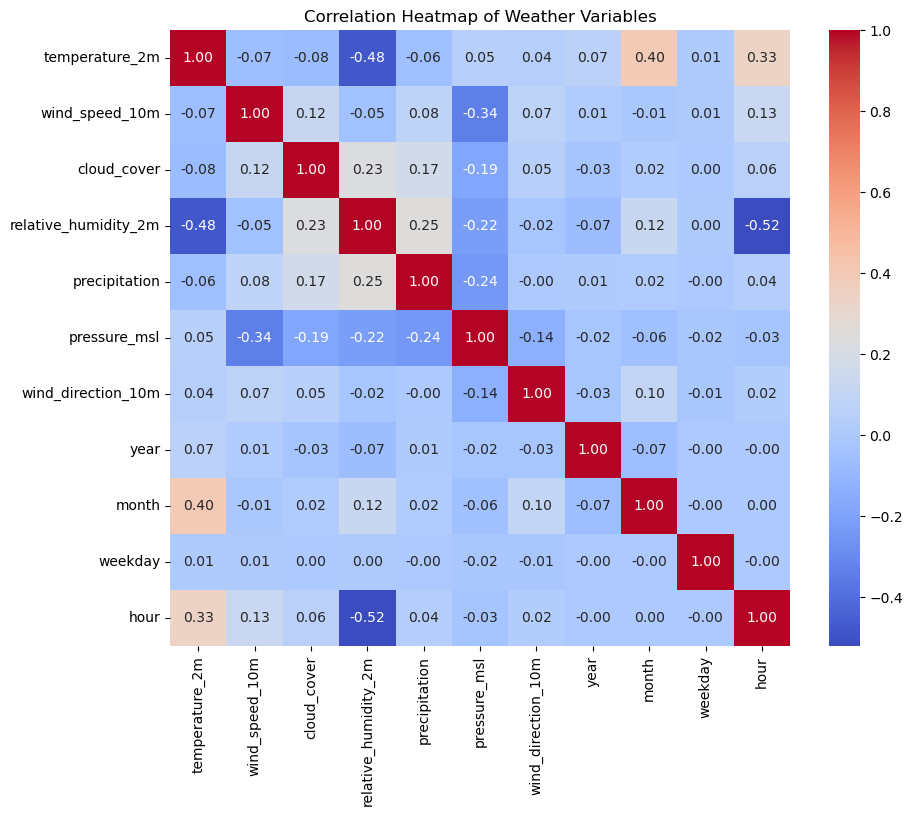

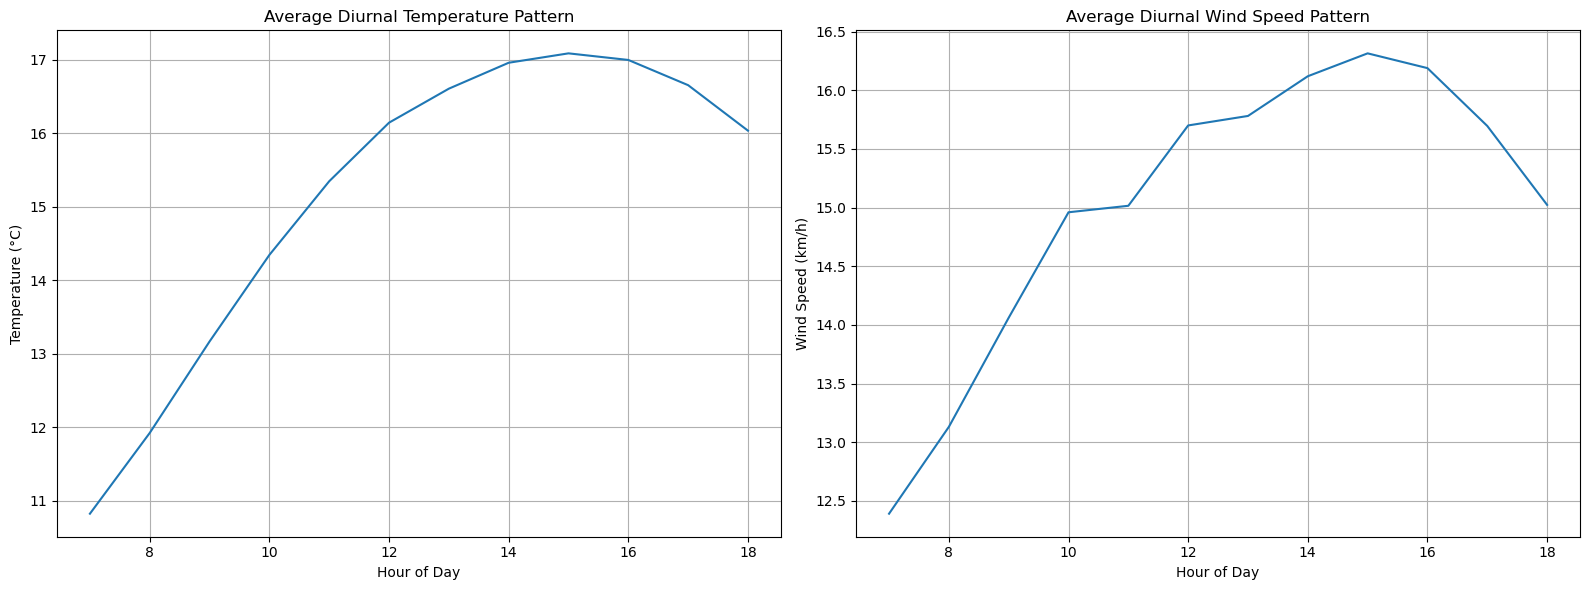


These charts show the average pattern of temperature and wind speed throughout the day.


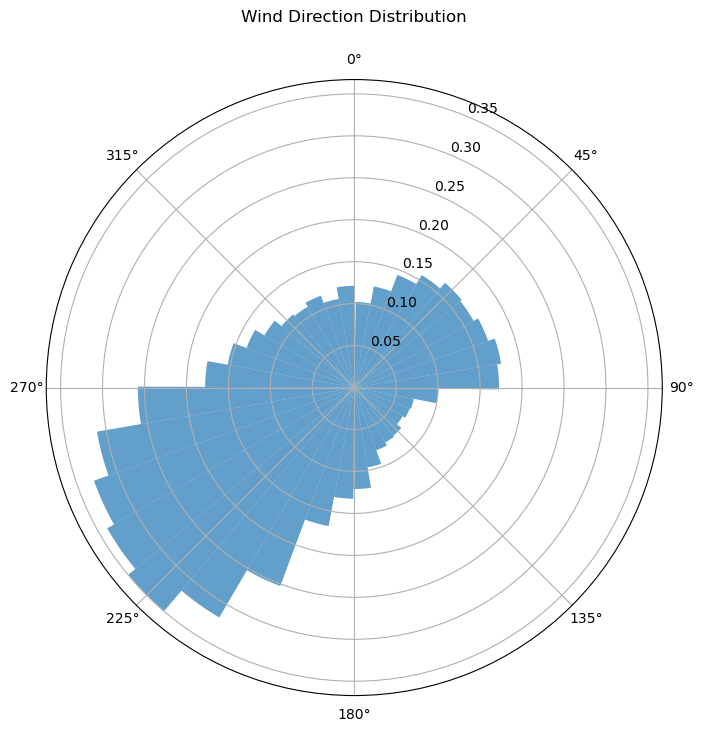


This wind rose shows the most common wind directions (e.g., from the South-West).


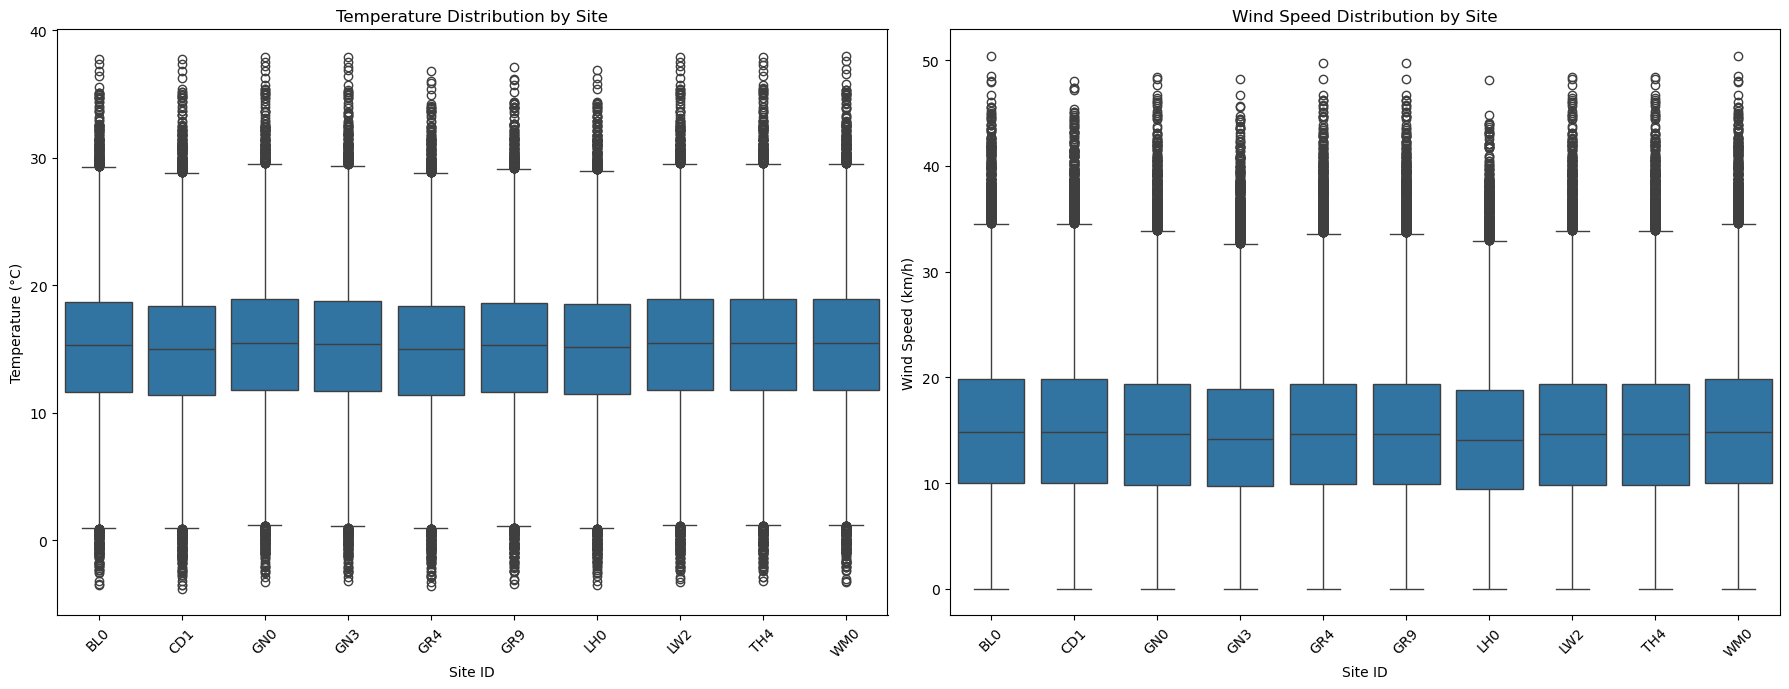


These boxplots help verify that the weather is broadly similar across all sites, as expected for one city.


In [47]:
# Plot 1: Correlation Heatmap of Weather Variables
# This helps us understand which variables are related to each other.
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Weather Variables')
plt.show()


# Plot 2: Diurnal (Daily) Patterns for Key Variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(data=df, x='hour', y='temperature_2m', ax=axes[0], errorbar=None)
axes[0].set_title('Average Diurnal Temperature Pattern')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

sns.lineplot(data=df, x='hour', y='wind_speed_10m', ax=axes[1], errorbar=None)
axes[1].set_title('Average Diurnal Wind Speed Pattern')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Wind Speed (km/h)')
axes[1].grid(True)
plt.tight_layout()
plt.show()
print("\nThese charts show the average pattern of temperature and wind speed throughout the day.")

# Plot 3: Wind Direction Distribution (Wind Rose)
# This plot is excellent for showing dominant wind directions.
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
wind_rad = np.radians(df["wind_direction_10m"])
# Use density=True for a probability distribution view
ax.hist(wind_rad, bins=36, density=True, alpha=0.7, label='Direction Frequency')
ax.set_theta_zero_location('N') # Set 0 degrees to North
ax.set_theta_direction(-1) # Set direction to clockwise
plt.title("Wind Direction Distribution", y=1.08)
plt.show()
print("\nThis wind rose shows the most common wind directions (e.g., from the South-West).")

# Plot 4: Variation of Weather by Site
# This checks if there are significant differences between your 10 locations.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.boxplot(data=df, x='siteid', y='temperature_2m', ax=axes[0])
axes[0].set_title('Temperature Distribution by Site')
axes[0].set_xlabel('Site ID')
axes[0].set_ylabel('Temperature (°C)')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df, x='siteid', y='wind_speed_10m', ax=axes[1])
axes[1].set_title('Wind Speed Distribution by Site')
axes[1].set_xlabel('Site ID')
axes[1].set_ylabel('Wind Speed (km/h)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
print("\nThese boxplots help verify that the weather is broadly similar across all sites, as expected for one city.")